# Agenda
1. [What is validation and why do we need it?](#Intro)
2. [Evaluation Metrics:](#metrics) <br>
    2.1 [Optimization Loss and Evaluation Metrics](#loss_and_metric) <br>
    2.2 [Classification metrics](#classification_metrics) <br>
    2.3 [Regression metrics](#regression_metrics) <br>
    2.4 [Metrics in ASR and TTS tasks](#generative_metrics) <br>
3. [Validation Strategies:](#validation_strategies) <br>
    3.1 [Overfitting. Why do we need train/test concept?](#overfitting) <br>
    3.2 [Holdout / Stratified split / train-validation-test](#holdout) <br>
    3.3 [K-fold / Stratified K-fold / Repeated K-fold](#kfold) <br>
    3.4 [Time-based validation / Time K-fold](#timebased) <br>
    3.5 [Group K-fold](#groupkfold) <br>
    3.6 [Choosing the right strategy for real-life scenarios and competition LB consistency](#strategychoose) <br>
4. [Local validation VS real-life/competition testing metrics mismatch](#validation_mismatch) <br>
    4.1 [Wrong local validation strategy](#wrong_local_validation) <br>
    4.2 [Shifted features distributions](#shifted_features) <br>
    4.3 [Adversarial validation](#adversarial_validation) <br>
5. [Homework](#Homework)

<a id='Intro'></a>
# What is validation and why do we need it?

The ML models validation process is a crucial step in developing machine learning models. It involves assessing the performance and generalization capabilities of a trained model to ensure that it can make accurate predictions on new, unseen data. There are such key points in evaluating models:

**Generalization performance** - We want to estimate the predictive performance of our model on future (unseen) data.
- Ideally, the estimated performance (based on evaluation metrics) of a model tells us how well it performs on unseen data, because making predictions on future (unseen) data is often the main problem we want to solve.

**Hyperparameters tuning and feature engineering** - We want to increase the predictive performance by tweaking the learning algorithm and selecting the best performing model from a given hypothesis space.
- Typically, machine learning involves a lot of experimentation. Running a learning algorithm over a training dataset with different hyperparameter settings and different features will result in different models. Since we are typically interested in selecting the best-performing model from this set, we need to find a way to estimate their respective performances in order to rank them against each other.

**Model selection** - We want to compare different ML models (e.g. linear, decision tree, gradient boosting, etc.), selecting the best-performing one.
- We are usually not only experimenting with the one single algorithm that we think would be the “best solution” under the given circumstances. More often than not, we want to compare different models to each other, oftentimes in terms of predictive and computational performance.

<a id='metrics'></a>
# 2. Evaluation metrics
An evaluation metric, in the context of machine learning and data analysis, is a quantitative measure used to assess the performance or quality of a model or a system's output with respect to a specific task or objective. Evaluation metrics are crucial because they provide a standardized way to measure and compare the performance of different models or systems. The choice of evaluation metric depends on the nature of the task being addressed (e.g. classification, regression, ranking) and the specific goals and requirements of the project.

<a id='loss_and_metric'></a>
## 2.1 Optimization Loss and Evaluation Metrics
Optimization loss and evaluation metrics serve different roles in the context of machine learning model training and evaluation. Here are the key differences between the two: <br>
1. **Purpose**: <br>
    **Optimization Loss:** often simply referred to as "loss", is a mathematical function that the machine learning model aims to minimize during training. It serves as the objective function that guides the model's parameter updates during optimization. The primary purpose of the loss function is to measure the dissimilarity between the model's predictions and the true target values. It provides the model with a signal for adjusting its internal parameters to improve its predictive performance on the training data. The model's parameters are updated in the direction that reduces this loss, using techniques like gradient descent.<br>
    **Evaluation Metric:** used to assess the model's performance and quality after it has been trained and to evaluate how well it generalizes to new, unseen data. These metrics are not used during training but rather during the model evaluation phase to provide a quantitative measure of how well the model is achieving its intended task. Evaluation metrics are often chosen based on the specific problem and the practical goals of the application.
    
2. **Function properties:** <br>
    **Optimization Loss:** differentiable "almost everywhere" with respect to model parameters function that is well-suited for gradient-based optimization algorithms. Common examples include mean squared error (MSE), mean absolute error (MAE) for regression tasks and cross-entropy loss for classification tasks. <br>
    **Evaluation Metric:** both continuous and discrete, are usually much better interpretable than loss, depending on the nature of the task. Examples include accuracy, precision, recall, F1-score, roc-auc, mean absolute percentage error, etc.
    

### What are "good" and "bad" properties of different evaluation metrics?

- **differentiability "almost everywhere"** - is definitely a good property, because this kind of a metrics could serve as a training loss, so you can directly optimize it with SGD-based methods.
- **multiclass/multivariate extensibility** - is definitely a good property, because in many real-life tasks you'll need to handle multicalss/multivariate ML problems, so you can extend your regular metric to them.
- **reference values** - is definitely a good property, because if the metric has some reference values (e.g. ROCAUC=0.5), then without deep-diving into the problem itself and the nature of the data, we can immediately say whether the solution is rather good or not.
- **interpretability** - is rather good property. When we talk about interpretability in terms of ML evaluation metrics, we're often discussing how understandable the metrics themselves are (especially by people without a deep background in ML), as well as how well they allow us to interpret the performance and characteristics of the model. Although, understanding more complex and less interpretable metrics fully may require some background knowledge, but they may provide deeper insights into some specific aspects of model performance.
- **values limitation** - is rather good property, because if metric values are limited in some specific range is there is no risk of getting +-infinity values, with which it is not very clear what to do.
- **outliers resistance** - is rather a good property, but only for problems in which outliers are not so important, e.g. in algo-trading there could be "outlier"-like situations in the market which can lead to your algorithm losing most of its money at once -> so you'll need to take care of outliers and doesn't use outlier-resistant metrics.
- **equivalence of accounting for errors of the first and second types** - very much depends on the business task itself. E.g. in the classical credit scoring problem you would rather lend to fewer people, but who will definitely return your money, than to a much larger number of people who will not return your money (precision-based optimization), on the other hand in the task of primary disease diagnosis it is much more important to correctly identify all people with a disease, while falsely identifying healthy people as sick, than to very accurately identify those who are sick while missing half (recall-based optimization)

## Example dataset overview
[Common Language Dataset](https://huggingface.co/datasets/common_language) <br>
![](../images/common_languages_structure.png) <br>
 - This dataset has been already split into the train/validation/test parts using some specific logic. We will use train/dev parts as a local train and the test part as a "kaggle leaderboard" test.
 - In this lecture we will consider 2 main tasks for this dataset: gender detection and age group classification

In [ ]:
!curl -o ../../data/CommonLanguage.tar.gz https://zenodo.org/records/5036977/files/CommonLanguage.tar.gz?download=1
!tar -xvzf ../../data/CommonLanguage.tar.gz -C ../../data/

In [1]:
import pandas as pd
import glob

df_train = []
df_test = []

for language_dir in glob.glob('../../data/common_voice_kpd/*'):
    language = language_dir.split('/')[-1]
    df_train_current = pd.read_csv(
        f'{language_dir}/train.csv', encoding='utf-16', sep='\t'
    )
    df_train_current['language'] = language
    df_train.append(df_train_current)
    
    df_dev_current = pd.read_csv(
        f'{language_dir}/dev.csv', encoding='utf-16', sep='\t'
    )
    df_dev_current['language'] = language
    df_train.append(df_dev_current)
    
    df_test_current = pd.read_csv(
        f'{language_dir}/test.csv', encoding='utf-16', sep='\t'
    )
    df_test_current['language'] = language
    df_test.append(df_test_current)
    

df_train = pd.concat(df_train).reset_index(drop=True).drop(columns=['Unnamed: 0'])
df_test = pd.concat(df_test).reset_index(drop=True).drop(columns=['Unnamed: 0'])

audio_paths = glob.glob('../../data/common_voice_kpd/*/*/*/*.wav')
audio_paths_mapping = {p.split('/')[-1]: p for p in audio_paths}

df_train['full_path'] = df_train.path.map(audio_paths_mapping)
df_test['full_path'] = df_test.path.map(audio_paths_mapping)

In [2]:
df_train.sample(5)

,client_id,path,sentence,age,gender,language,full_path
4899,eng_trn_sp_400,common_voice_en_521512.wav,"""Should I understand the Emerald Tablet?"" the ...",not_defined,not_defined,English,../../data/common_voice_kpd/English/train/eng_...
19925,grmn_trn_sp_520,common_voice_de_19999493.wav,"Monarchie, kam Biecz zu Polen.",not_defined,not_defined,German,../../data/common_voice_kpd/German/train/grmn_...
1194,kyr_trn_sp_55,common_voice_ky_17404115.wav,Бизге бардык сметалык документтерди РусГидро б...,not_defined,not_defined,Kyrgyz,../../data/common_voice_kpd/Kyrgyz/train/kyr_t...
17502,latv_trn_sp_70,common_voice_lv_19420768.wav,Vajadzīga palīdzība.,thirties,male,Latvian,../../data/common_voice_kpd/Latvian/train/latv...
11441,tml_trn_sp_100,common_voice_ta_19965901.wav,சாய்வு நாற் காலியில் சாய்ந்திருந் தவரின்,twenties,male,Tamil,../../data/common_voice_kpd/Tamil/train/tml_tr...


In [3]:
df_train.gender.value_counts(normalize=True)

not_defined    0.523930
male           0.369952
female         0.100812
other          0.005306
Name: gender, dtype: float64

In [4]:
df_train.age.value_counts(normalize=True)

not_defined    0.524856
twenties       0.212485
thirties       0.141692
teens          0.044299
fourties       0.041949
fifties        0.023253
sixties        0.010078
seventies      0.000819
eighties       0.000427
nineties       0.000142
Name: age, dtype: float64

In [7]:
import librosa
import torch
import numpy as np
from transformers import (
    AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC, 
    AutoProcessor, Wav2Vec2Model, HubertForCTC, 
    HubertModel, Data2VecAudioForCTC, Data2VecAudioModel,
    AutoModelForAudioXVector
)
from tqdm.autonotebook import tqdm

class XVectorExtractor:
    def __init__(
        self,
        model_name,
        device="cpu",
        do_normalize=True
    ):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)
        self.do_normalize = do_normalize

    def extract_features(
        self,
        wave_pathes,
        sample_rate
    ):
        features = []
        for wave_path in tqdm(wave_pathes):
            wave, _ = librosa.load(wave_path, sr=sample_rate)
            inputs = self.feature_extractor([wave], sampling_rate=sample_rate, return_tensors="pt").input_values
            with torch.no_grad():
                embeddings = self.model(inputs.cuda()).embeddings
            if self.do_normalize:
                embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            embeddings = embeddings.cpu()
            features.append(embeddings)
        return torch.cat(features, dim=0)
    
w2v2_xvector_model = XVectorExtractor(
    model_name="anton-l/wav2vec2-base-superb-sv",
    device="cuda",
    do_normalize=True
)

Some weights of the model checkpoint at anton-l/wav2vec2-base-superb-sv were not used when initializing Wav2Vec2ForXVector: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForXVector were not initialized from the model checkpoint at anton-l/wav2vec2-base-superb-sv and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should pr

In [66]:
train_w2v2_embs = w2v2_xvector_model.extract_features(
    df_train.full_path.tolist(),
    sample_rate=16_000
)

test_w2v2_embs = w2v2_xvector_model.extract_features(
    df_test.full_path.tolist(),
    sample_rate=16_000
)

np.save("../../data/w2v2_train_xvectors.npy", train_w2v2_embs.numpy())
np.save("../../data/w2v2_test_xvectors.npy", test_w2v2_embs.numpy())

In [8]:
train_w2v2_embs = np.load("../../data/w2v2_train_xvectors.npy")
test_w2v2_embs = np.load("../../data/w2v2_test_xvectors.npy")

In [9]:
from sklearn.preprocessing import LabelEncoder


binary_gender_mask_train = df_train.gender.isin(['male', 'female'])
binary_gender_mask_test = df_test.gender.isin(['male', 'female'])

df_train_gender = df_train[binary_gender_mask_train].reset_index(drop=True)
df_test_gender = df_test[binary_gender_mask_test].reset_index(drop=True)

y_train = df_train_gender.gender.map({'male': 0, 'female': 1})
y_test = df_test_gender.gender.map({'male': 0, 'female': 1})

X_train = train_w2v2_embs[binary_gender_mask_train]
X_test = test_w2v2_embs[binary_gender_mask_test]

In [10]:
y_train.value_counts(normalize=True)

0    0.785855
1    0.214145
Name: gender, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.813477
1    0.186523
Name: gender, dtype: float64

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline


pipe_classification = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(random_state=42, max_iter=1000))
])

pipe_classification.fit(X_train, y_train)

y_hat = pipe_classification.predict_proba(X_test)[:, 1]

<a id='classification_metrics'></a>
## 2.2 Classification metrics

Examples of classification tasks in the audio processing domain:
- Speaker Identification and Verification: These tasks focus on recognizing who is speaking. Identification involves determining the identity of the speaker from a group of known voices, while verification checks if the voice belongs to a claimed identity. Such technologies are crucial for security systems and personalized voice services.
- Music Genre Classification: This task classifies music tracks into genres (e.g., rock, classical, jazz) based on their audio features. It's used in music streaming services for playlist curation and recommendation algorithms.
- Emotion Recognition: This involves identifying emotional states (e.g., happy, sad, angry) from vocal expressions in audio clips. It has applications in customer service to gauge caller satisfaction and in interactive entertainment to adjust content based on the user's emotional state.
- Sound Event Detection and Classification: This task identifies and classifies sounds within an audio clip into categories like animal noises, vehicle sounds, or environmental sounds. It's used in surveillance systems, wildlife monitoring, and urban planning to understand the acoustic environment.
- Language Identification: This task identifies the language spoken in an audio clip, crucial for multilingual speech recognition systems and global communication services.

A binary machine learning classification task is a type of supervised learning problem in which the goal is to categorize data points into one of two distinct classes or categories. In other words, the output or prediction of the model is the probability distribution of an element belonging to the corresponding classes. These two classes are often referred to as the positive class and the negative class. The objective is to learn a model that can accurately classify new, unseen data points into one of these two classes based on the features or attributes of the data.


$$Let \hspace{0.1cm} Y = \Bigl\{ y_{i} \Bigl\} \hspace{0.1cm} - \hspace{0.1cm} vector \hspace{0.1cm} of\hspace{0.1cm} ground\hspace{0.1cm} truth\hspace{0.1cm} labels \hspace{0.5cm}  y_{i} є \{0, 1\}$$
$$Let \hspace{0.1cm} \hat{Y} = \Bigl\{ \hat{y_{i}} \Bigl\} \hspace{0.1cm} - \hspace{0.1cm} vector \hspace{0.1cm} of\hspace{0.1cm} predicted\hspace{0.1cm} probabilities\hspace{0.1cm} of \hspace{0.1cm} class \hspace{0.1cm} 1 \hspace{0.5cm} \hat{y_{i}} є [0, 1]$$
### Continuous metrics:
**Log-Loss / Cross-Entropy Loss** <br>
$$ LogLoss = {-\frac{1}{N} \sum_{i=1}^{N}(y_{i}log(\hat{y_{i}})+(1-y_i)log(1-\hat{y_{i}}))}$$
##### Pros:
    + Differentiable
    + Could be a loss
    + Impact of misclassification confidence: Log loss takes into account the model's confidence in its predictions. If a model is highly confident in an incorrect prediction, it will result in a higher log loss than a less confident incorrect prediction
    + Multiclass extension: Log loss can be extended to multiclass classification problems, where there are more than two classes

##### Cons:
    - Poorly interpretable (especially for people without IT/ML background)
    - Not limited: Log loss values range from 0 to positive infinity
    - Doesn't have "reference values": without knowing the task and classes distribution it's hard to tell whether e.g. 0.1/0.5/1.5 refers to a rather "good" or "poor" model performance 

In [13]:
from sklearn.metrics import log_loss

log_loss(y_test, y_hat)

0.10740000033581576

### Discrete metrics:

In the discrete metric case we work with "hard" labels intead of "soft" labels or probabilities. Soft labels can be transformed into hard labels for example using threshold for binary classification: e.g. if value > 0.5 then we consider it as a positive class and replace it with 1; otherwise we consider it as a negative class and replace it with 0.

In order to introduce all common discrete metrics we need to get familiar with the **confusion matrix** that consists of 4 components:
- **TP (True Positive)** - number of pairs for which $y_{i}=1$ and $hard\_label(\hat{y_{i}})=1$ i.e. number of positives that were predicted as positives by the model
- **TN (True Negative)** - number of pairs for which $y_{i}=0$ and $hard\_label(\hat{y_{i}})=0$ i.e. number of negatives that were predicted as negatives by the model
- **FP (False Positive)** - number of pairs for which $y_{i}=0$ and $hard\_label(\hat{y_{i}})=1$ i.e. number of negatives that were predicted as positives by the model
- **FN (False Negative)** - number of pairs for which $y_{i}=1$ and $hard\_label(\hat{y_{i}})=0$ i.e. number of positives that were predicted as negatives by the model

![](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/63b413d2cdc133446aa23fc5_636b9182cfaef2115e028921_HERO_1_Confusion.png)

In [14]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_hat >= 0.5))

[[3067  108]
 [  37  691]]


|                | Predicted Negative | Predicted Positive |
|:--------------:|--------------------|--------------------|
| **Negative Cases** |      TN: 3067      |      FP: 108      |
| **Positive Cases** |      FN: 37      |      TP: 691     |

**Accuracy** <br>
Accuracy simply measures *what percent of your predictions were correct*. It's the ratio between the number of correct predictions and the total number of predictions. The downside is that it is hard to optimize and it cares about hard labels

$$accuracy = {\frac{TP + TN}{TP + FP + FN + TN}}$$

##### Pros:
    + Highly interpretable by non-technical people
    + Limited in range [0, 1]
    + Multiclass extension: can be extended to multiclass classification problems, where there are more than two classes

##### Cons:
    - Not resistant to class imbalance
    - Doesn't have "reference values": without knowing the task and classes distribution it's hard to tell whether e.g. 0.6/0.8/0.99 refers to a rather "good" or "poor" model performance. However, the percentage of the majority class may be considered as a reference value if we know the class distribution.

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_hat >= 0.5)

0.9628490904432487

**Precision & Recall**

Precision and recall are actually two metrics. But they are often used together.

**Precision** answers the question: *What percent of positive predictions were correct?*

$$precision = {\frac{TP}{TP + FP}}$$

**Recall** answers the question: *What percent of the positive cases was catched?*

$$recall = {\frac{TP}{TP + FN}}$$

##### Pros:
    + Highly interpretable by non-technical people
    + Limited in range [0, 1]
    + Multiclass extension: can be extended to multiclass classification problems, where there are more than two classes

##### Cons:
    - Doesn't take into account TN
    - Do not make sense without each other
    - Strongly depend on the threshold

**F1-score**
The F1-score (sometimes known as the balanced F-beta score with beta=1) is a single metric that combines both precision and recall via their harmonic mean:

$$F_1 = 2*{\frac{precision * recall}{precision + recall}}$$

Unlike the arithmetic mean, the harmonic mean tends toward the smaller of the two elements. Hence the F1 score will be small if either precision or recall is small.
We actually need F1 score because in many cases we can make precision almost as close to 1 as possible but this will result a poor recall and vice-versa.

##### Pros:
    + Limited in range [0, 1]
    + Suitable for imbalanced classes case
    + Multiclass extension: can be extended to multiclass classification problems, where there are more than two classes

##### Cons:
    - Poorly interpretable (especially for people without IT/ML background)
    - Doesn't take into account TN
    - Strongly depend on the threshold

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

f_metrics = []
tholds = [0.1, 0.25, 0.5, 0.75, 0.9]
for th in [0.1, 0.25, 0.5, 0.75, 0.9]:
    f_metrics.append({
        'positives_ratio': (y_hat >= th).sum()/y_hat.shape[0],
        'precision': precision_score(y_test, y_hat >= th),
        'recall': recall_score(y_test, y_hat >= th),
        'f1': f1_score(y_test, y_hat >= th),
    })
pd.DataFrame(f_metrics, index=tholds)

,positives_ratio,precision,recall,f1
0.10,0.279272,0.663303,0.993132,0.795380
0.25,0.235460,0.776931,0.980769,0.867031
0.50,0.204714,0.864831,0.949176,0.905043
0.75,0.178581,0.913917,0.875000,0.894035
0.90,0.144248,0.943162,0.729396,0.822618


**ROC-AUC**

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

- **TPR/Recall** - *What percent of the positive cases was catched?* 
$$TPR = {\frac{TP}{TP + FN}}$$
- **FPR/Fall-out** - *What percent of negatives would be classified as positives?* 
$$FPR = {\frac{FP}{FP + TN}}$$

$$ROCAUC = \int_{t=0}^{1} TPR(t) \,dFPR(t)$$

![](https://machinelearningmastery.com/wp-content/uploads/2018/08/ROC-Curve-Plot-for-a-No-Skill-Classifier-and-a-Logistic-Regression-Model.png)

##### Pros:
    + Limited in range [0, 1]
    + Doesn't depend on the threshold
    + Takes all TP/FP/FN/TN into account
    + Has some reference values, e.g. 0.5 - random prediction, 0.8-0.9 in balanced case - good, ~1 ideal prediction, 
    
##### Cons:
    - Poorly interpretable (especially for people without IT/ML background)
    - Doesn't distinguish between different types of errors (false positives and false negatives). In some imbalanced scenarios, you may want to prioritize one type of error over the other.
    
**PRECISION-RECALL-AUC**

The PRECISION-RECALL curve is created by plotting Precision against Recall at various threshold settings.


$$PRECISION\_RECALL\_AUC = \int_{t=0}^{1} PRECISION(t) \,dRECALL(t)$$

![](https://machinelearningmastery.com/wp-content/uploads/2020/01/Precision-Recall-Curve-of-a-Logistic-Regression-Model-and-a-No-Skill-Classifier2.png)

##### Pros:
    + Limited in range [0, 1]
    + Doesn't depend on the threshold
    + Very useful for tasks with a huge class imbalance
    
##### Cons:
    - Poorly interpretable (especially for people without IT/ML background)
    - Doesn't take into account TN
    - Doesn't have reference values

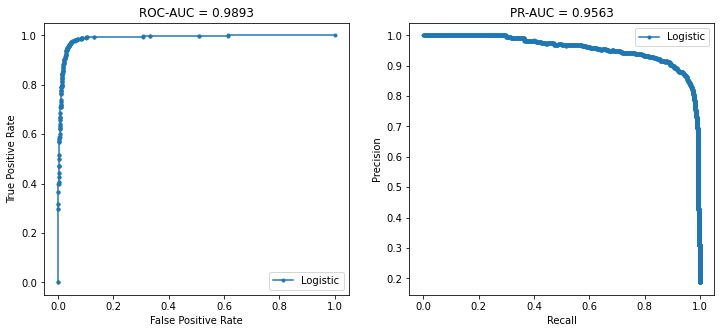

In [17]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

fig, axs = pyplot.subplots(1, 2, figsize=(12, 5))

# plot no skill and model roc curves
def plot_roc_curve(test_y, model_probs, ax):
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    ax.plot(fpr, tpr, marker='.', label='Logistic')
    ax.set_title(f'ROC-AUC = {roc_auc_score(test_y, model_probs):.4f}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    
# plot model precision-recall curves
def plot_pr_curve(test_y, model_probs, ax):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    ax.plot(recall, precision, marker='.', label='Logistic')
    ax.set_title(f'PR-AUC = {auc(recall, precision):.4f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()


plot_roc_curve(y_test, y_hat, axs[0])
plot_pr_curve(y_test, y_hat, axs[1])
pyplot.show()

### Imbalanced classes case

In [18]:
negative_class_index = y_test[y_test == 0].index
positive_class_index = y_test[y_test == 1].sample(frac=0.05).index
imbalanced_sumsample_index = negative_class_index.append(positive_class_index)

y_test_imbalanced = y_test.loc[imbalanced_sumsample_index]
y_hat_imbalanced = pipe_classification.predict_proba(pd.DataFrame(X_test).loc[imbalanced_sumsample_index])[:, 1]

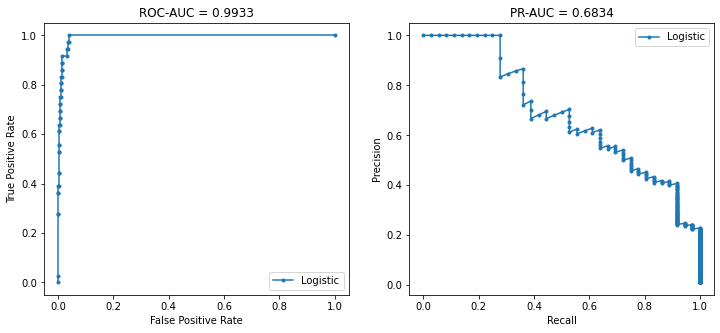

In [19]:
fig, axs = pyplot.subplots(1, 2, figsize=(12, 5))

plot_roc_curve(y_test_imbalanced, y_hat_imbalanced, axs[0])
plot_pr_curve(y_test_imbalanced, y_hat_imbalanced, axs[1])
pyplot.show()

> **Explore**: check multiclass/multilabel extensions (equations and implementations) for all common classification metrics (accuracy, precision, recall, $F1$/$F\beta$)

### Choosing a correct loss function for a given metric optimization
![](https://scikit-learn.org/stable/_images/sphx_glr_plot_sgd_loss_functions_001.png)

In [20]:
from sklearn.linear_model import SGDClassifier

pipe_classification_log_loss = Pipeline([
    ("scaler", StandardScaler()),
    ('classifier', SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1))
])

pipe_classification_log_loss.fit(X_train, y_train)
y_hat_log_loss = pipe_classification_log_loss.predict_proba(X_test)[:, 1]


pipe_classification_huber = Pipeline([
    ("scaler", StandardScaler()),
    ('classifier', SGDClassifier(loss='modified_huber', random_state=42, n_jobs=-1))
])

pipe_classification_huber.fit(X_train, y_train)
y_hat_huber = pipe_classification_huber.predict_proba(X_test)[:, 1]

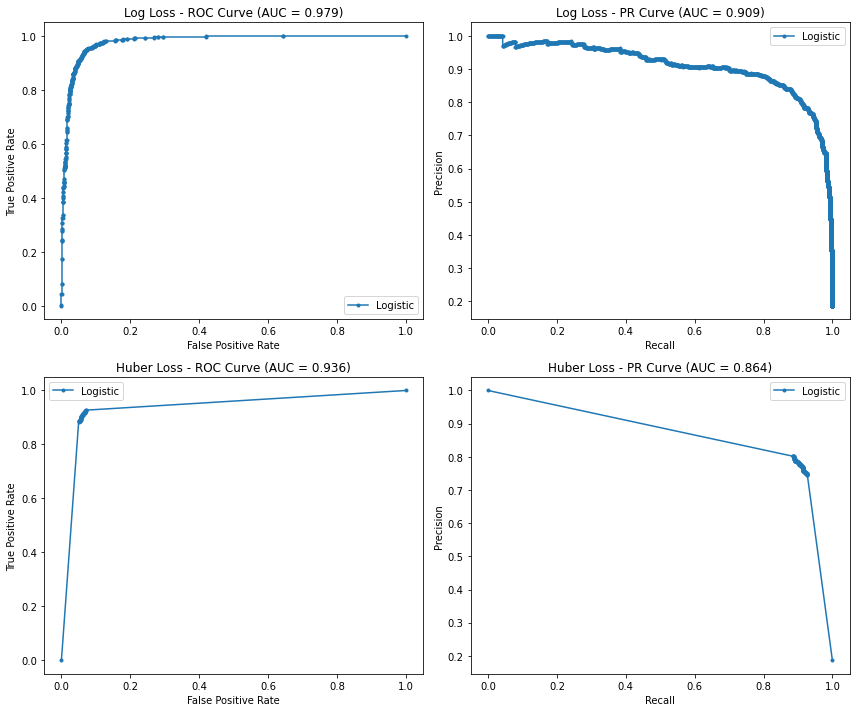

In [21]:
precision_log_loss, recall_log_loss, _ = precision_recall_curve(y_test, y_hat_log_loss)
precision_huber, recall_huber, _ = precision_recall_curve(y_test, y_hat_huber)

fig, axs = pyplot.subplots(2, 2, figsize=(12, 10))

plot_roc_curve(y_test, y_hat_log_loss, axs[0, 0])
plot_pr_curve(y_test, y_hat_log_loss, axs[0, 1])

plot_roc_curve(y_test, y_hat_huber, axs[1, 0])
plot_pr_curve(y_test, y_hat_huber, axs[1, 1])

axs[0, 0].set_title(f'Log Loss - ROC Curve (AUC = {roc_auc_score(y_test, y_hat_log_loss):.3f})')
axs[0, 1].set_title(f'Log Loss - PR Curve (AUC = {auc(recall_log_loss, precision_log_loss):.3f})')
axs[1, 0].set_title(f'Huber Loss - ROC Curve (AUC = {roc_auc_score(y_test, y_hat_huber):.3f})')
axs[1, 1].set_title(f'Huber Loss - PR Curve (AUC = {auc(recall_huber, precision_huber):.3f})')

# Adjust layout and display the subplots
pyplot.tight_layout()
pyplot.show()

### Thoughts about model selection using evaluation metrics

**Within the framework of solving a classification problem, when there are different approaches or models that model the target distribution, in order to compare them with each other, it is better to use AUC-like metrics, since they do not depend on the threshold, and in the case of such metrics, higher values always correspond to a better, in some sense, modeling of the target distribution. But the final business decision usually should be made with respect to "hard" e.g. precision/recall metrics, because in real-life scenarios we usually need "hard" labels and not probabilities.**

<a id='regression_metrics'></a>
## 2.3 Regression metrics

Examples of regression tasks in the audio processing domain:
- Room Acoustics Analysis: Estimating acoustic parameters of a room, such as reverberation time (RT60), from an audio recording. These parameters describe how sound behaves in a space and are essential for designing audio systems in buildings and for virtual reality simulations.
- Sound Source Localization: Predicting the position of a sound source relative to a microphone array. This involves estimating the angle of arrival or the distance of sound sources, which is key for applications like surveillance systems, hearing aids, and robotic navigation.
- Emotional Intensity or Valence Prediction: In emotion recognition tasks, predicting the degree of an emotion (e.g., how angry or happy someone sounds) or the valence (positive or negative emotional charge) from speech, which can be used in customer service to assess caller satisfaction more finely.
- Beat Tracking and Tempo Estimation: Estimating the tempo (beats per minute) of a musical piece or the precise timing of beats. This is crucial for music analysis, DJ software, and applications that automatically synchronize music with visuals or other music tracks.
- Age Estimation from Voice: Predicting the age of a speaker based on vocal characteristics. This can be used in demographic studies, targeted advertising, and enhancing voice recognition systems.

A regression task, in machine learning, is a type of supervised learning problem where the goal is to predict a continuous numeric value or a real number. In regression tasks, the target variable is continuous, and the model's objective is to learn a mapping from input features to this continuous output.

**MSE (L2 Loss) and RMSE:** <br>
MSE measures your mean square error from target:


$$ MSE = {\frac{1}{N} \sum_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}$$

$$ RMSE = {\sqrt{MSE}}$$

RMSE and MSE is similiar in terms of minimizers — value minimizes RMSE **if and only if** it minimizes MSE. This means that in terms of competitions we can optimize MSE instead of RMSE. In fact it is easier to work with MSE. But there is a little bit of difference between the two for gradient-based models. The gradient of RMSE with respect to i-th prediction is basically equal to gradient of MSE multiplied by some value. The value doesn't depend on the index I. It means that travelling along MSE gradient is equivalent to traveling along RMSE gradient but with a different flowing rate and the flowing rate depends on MSE score itself. So, it is kind of dynamic. So even though RMSE and MSE are really similar in terms of models scoring, they can be not immediately interchangeable for gradient based methods. We will probably need to adjust some parameters like the learning rate.

##### Pros:
    + Differentiable
    + Could be a loss
    + According to the Gauss-Markov theorem optimizing MSE results in BLUE (The best linear unbiased estimator) for linear models if the conditions of the theorem are fulfilled

##### Cons:
    - Sensitive to outliers: Optimizing MSE could produce a non-robust estimator
    - Doesn't have reference values: without knowing the scale of the target variable it's hard to tell whether e.g. 0.5/5/50 values are good or not

**R-squared** <br>
To see model performance in terms of dummy baseline usually R-squared is used. Or Adjusted R-squared to penalize for model parameters/features

$$ R^2 = 1 - {\frac{MSE}{\frac{1}{N} \sum_{i=1}^{N}(y_{i}-\bar{y_{i}})^2}}$$

In a normal scenario R-squared should be between 0 and 1.

##### Pros:
    + Differentiable
    + Could be a loss
    + Has reference values: < 0 -> model performs worse than the "blind guess"; greater than 0 -> model performs better than the "blind guess"; ~1 - we have a perfect model

##### Cons:
    - Sensitive to outliers
    
#### Outliers case:
![](https://machinelearningmastery.com/wp-content/uploads/2020/03/Comparison-of-Robust-Regression-Algorithms-Line-of-Best-Fit.png)

**MAE (L1 Loss / Manhattan Distance):**

$$ MAE = {\frac{1}{N} \sum_{i=1}^{N}|y_{i}-\hat{y_{i}}|} $$

##### Pros:
    + Differentiable "almost everywhere". Although, it is not differentiable in 0, but you can simply overcome that by coding simple *if else* condition.
    + Could be a loss
    + Less sensitive to outliers, so produces more robust estimators

##### Cons:
    - Doesn't have reference values: without knowing the scale of the target variable it's hard to tell whether e.g. 0.5/5/50 values are good or not


**Pearson Correlation** <br>

The Pearson correlation coefficient, often denoted as "r," is not typically used as a regression loss function in the traditional sense. Instead, it is a measure of the linear relationship or linear association between two continuous variables. It quantifies the strength and direction of the linear relationship between the ground truth target variable and predicted one. The Pearson correlation coefficient ranges from -1 to 1, with the following interpretations: <br>
$$ Cov(Y,\hat{Y}) ={\frac{1}{N-1}} \sum_{i=1}^{N}(y_{i} - \bar{y_{i}})*(\hat{y_{i}} - \bar{\hat{y_{i}}})$$

$$PearsonR = {\frac{Cov(Y,\hat{Y})}{STD(Y)*STD(\hat{Y})}}$$

##### Pros:
    + Differentiable
    + Could be a loss. Although, you need to update standard deviation of y_hat
    + Has reference values: [-1, 0] - negative linear correlation; [0, ~0.5] weak* linear correlation; [0.5-0.9] strong* linear correlation; [0.9-1] - almost perfect model;

##### Cons:
    - We can't say anything about absolute errors knowing only correlation coefficient
    - Could produce a low values, although it could be a solid monotonous correlation between y and y_hat

**Spearman Correlation** <br>

The Spearman Correlation coefficient, is calculated as a Pearson correlation coefficient between ranks of target and predicted variables: <br>

$$SpearmanR = PearsonR(rank(Y), rank(\hat{Y}))$$

##### Pros:
    + Sensitive for monotonous dependencies
    + Has reference values: [-1, 0] - negative monotonous correlation; [0, ~0.5] weak* monotonous correlation; [0.5-0.9] strong* monotonous correlation; [0.9-1] - almost perfect model;

##### Cons:
    - Non-differentiable
    - We can't say anything about absolute errors knowing only correlation coefficient

> **Explore**: check multivariate extensions (equations and implementations) for all common regression metrics (MAE, MSE, RMSE)

<a id='generative_metrics'></a>
## 2.4 Metrics in ASR and TTS tasks

In Automated Speech Recognition (ASR) tasks, the performance of a model is typically evaluated using several key metrics. These metrics help in understanding how well the model transcribes spoken language into text.

### ASR Metrics:

**Word Error Rate (WER):** <br>

$$WER = \frac{S + I + D}{N}$$

- S - a substitution occurs when a word gets replaced (for example, “noose” is transcribed as “moose”)
- I - an insertion is when a word is added that wasn’t said (for example, “SAT” becomes “essay tea”)
- D - a deletion happens when a word is left out of the transcript completely (for example, “turn it around” becomes “turn around”)
- N - number of words spoken

**Character Error Rate (CER):** <br>
Similar to WER, but operates at the character level instead of the word level. It's particularly useful for languages where the notion of a "word" is less clear, such as Chinese or Japanese. The formula for CER is similar to WER but uses characters instead of words.

### TTS Metrics:
In Text-to-Speech (TTS) systems, evaluating the quality and effectiveness of synthesized speech involves several metrics that can be categorized into subjective and objective measures. These metrics help to assess how natural, intelligible, and similar to human speech the generated audio is.

**Mean Opinion Score (MOS):**<br> 
This is a subjective quality metric where human listeners rate the quality of audio samples on a scale (typically 1 to 5). The scores are averaged to provide a measure of the perceived speech quality or naturalness. It's considered the gold standard in speech quality evaluation but is time-consuming and expensive to conduct.

**Comparison Mean Opinion Score (CMOS):** <br> 
In this approach, listeners are asked to compare the quality of two audio samples and rate the difference. This method is often used to assess the relative improvement or degradation in speech quality between different TTS systems.

**Mel Cepstral Distortion (MCD):** <br>
This metric calculates the distance between the Mel-frequency cepstral coefficients (MFCCs) of the synthesized speech and a reference (typically human speech). It's used to quantify the spectral distortion and assess the similarity in timbre and tone between synthesized and reference audio.

<a id='validation_strategies'></a>
# 3. Validation Strategies

<a id='overfitting'></a>
## 3.1 Overfitting. Why do we need train/test concept? <br>

We really don’t want to train and evaluate our model on the same dataset, since it would produce overfitting. In other words, we can’t tell whether the model simply memorized the training data or not, or whether it generalizes well to new, unseen data.

Let's look at the problem in more detail using a simple toy example:

In [22]:
import numpy as np
np.random.seed(42)

X_train = np.random.normal(0, 1, (500, 2))
noise_train = np.random.normal(0, 1., 500)

X_test = np.random.normal(0, 1, (100, 2))
noise_test = np.random.normal(0, 1., 100)

y_train = (np.sin(X_train) + np.cos(2*X_train)).sum(axis=1) + noise_train
y_test = (np.sin(X_test) + np.cos(2*X_test)).sum(axis=1) + noise_test

In [25]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

lr = Ridge(alpha=1.0, random_state=42)
lr.fit(X_train, y_train)

y_train_preds = lr.predict(X_train)
y_test_preds = lr.predict(X_test)

print(f'MSE on train: {mean_squared_error(y_train, y_train_preds)}\nMSE on test: {mean_squared_error(y_test, y_test_preds)}')

MSE on train: 2.046936920069584
MSE on test: 1.8647307030508085


Let's add some complexity (polynomial features) to the model and see what will happen with our metrics.

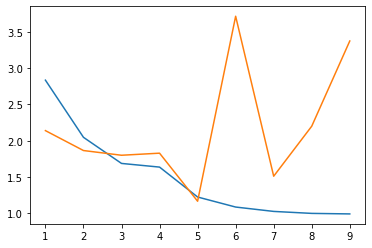

In [26]:
from matplotlib import pyplot as plt

train_result = []
test_result = []

for pow_n in range(1, 10):
    lr = Ridge(alpha=1.0, random_state=42)

    X_train_poly = np.hstack([X_train**(p) for p in range(pow_n)])
    X_test_poly = np.hstack([X_test**(p) for p in range(pow_n)])

    lr.fit(X_train_poly, y_train)

    y_train_preds = lr.predict(X_train_poly)
    y_test_preds = lr.predict(X_test_poly)
    
    train_result.append(mean_squared_error(y_train, y_train_preds))
    test_result.append(mean_squared_error(y_test, y_test_preds))
    
plt.plot(list(range(1, 10)), train_result, list(range(1, 10)), test_result)
plt.show()

Conclusion:
- We almost always can reach optimal loss (in MSE case ~0) for the training set by adding nonlinear feature / stacking more layers to the model
- We shouldn't stack layers and add features without proper control, because then we will get poor results in real-life testing / competition leaderboard
- So we need to somehow model real testing data using the only training dataset available

![](https://preview.redd.it/n9fgba8b0qr01.png?auto=webp&s=e86d2d3447c777d3222016e81a0adfaec1a95592)

#### In order to explore different validation strategies, we will solve the problem of predicting the speaker's age.

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


age_mask_train = df_train.age != 'not_defined'
age_mask_test = df_test.age != 'not_defined'

df_train_age = df_train[age_mask_train].reset_index(drop=True)
df_test_age = df_test[age_mask_test].reset_index(drop=True)

le = LabelEncoder().fit(df_train_age.age)

y_train = le.transform(df_train_age.age)
y_test = le.transform(df_test_age.age)

X_train = train_w2v2_embs[age_mask_train]
X_test = test_w2v2_embs[age_mask_test]

In [40]:
df_train_age.age.value_counts(normalize=True)

twenties     0.447201
thirties     0.298209
teens        0.093232
fourties     0.088286
fifties      0.048940
sixties      0.021210
seventies    0.001724
eighties     0.000899
nineties     0.000300
Name: age, dtype: float64

In [41]:
df_test_age.age.value_counts(normalize=True)

twenties     0.419441
thirties     0.368165
fourties     0.116160
fifties      0.045687
teens        0.044957
sixties      0.003159
seventies    0.002187
eighties     0.000243
Name: age, dtype: float64

<a id='holdout'></a>
## 3.2 Holdout / Stratified split / train-validation-test <br>

The holdout method is the simplest model evaluation technique. We take our labeled dataset and split it randomly into two parts: A **training set** and a **test set**:
![](https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing_01.png)
Then, we fit a model to the training data and predict the labels of the test set:
![](https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing_02.png)
And the fraction of correct predictions constitutes our estimate of the prediction accuracy.
![](https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing_03.png)

##### Pros:
    + Simple
    + Fast

##### Cons:
    - Not so precise estimate of out-of-sample performance comparing to more advanced techniques
    
### Class Balance

As it was said, you want your validation to mimic your test set as close as possible. And you can make a fair assumption (that is not always true), that distribution of target on train and not seen data is the same. Then you have to use stratification. Stratification ensures stable distributions across split. That is more than just useful if:

    + Dataset is small
    + Dataset is unbalanced (average target close to 0 or to 1)
    + You have a multiclassification task
    
    
### Model Checkpoint Selection

If we consider gradient-based training of models, for example neural networks or gradient boosting, then as a result of each epoch there will be some new model weights. Thus, the model at different epochs will behave differently on previously unseen data, so it is logical for the best result to choose a checkpoint from the epoch at which the target metric has the best values on previously unseen data.

However, by selecting the weights of the model in this way, we can also get some kind of overfit, since we choose these weights as the best according to the validation dataset, it is quite obvious that on average on any other previously unseen dataset the results of our model in terms of metrics will be worse.

Thus, in order to correctly select a model checkpoint after optimization or implement early stopping and also correctly estimate the results of the model on previously unseen data, we can apply train/validation/test strategy.

![](https://editor.analyticsvidhya.com/uploads/18265Screenshot-from-2020-10-06-16-35-50-768x432.png)

In [52]:
#straightforward train/test split

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

print(f'class distribution difference std: {(pd.Series(y_train_train).value_counts(normalize=True) - pd.Series(y_train_val).value_counts(normalize=True)).std()}')
pd.Series(y_train_train).value_counts(normalize=True) - pd.Series(y_train_val).value_counts(normalize=True)

class distribution difference std: 0.003993883190534275


0   -0.000500
1    0.003535
2   -0.001995
3   -0.000285
4   -0.000036
5   -0.004317
6    0.007569
7    0.001688
8   -0.005658
dtype: float64

In [53]:
#stratified train/test split

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)
print(f'class distribution difference std: {(pd.Series(y_train_train).value_counts(normalize=True) - pd.Series(y_train_val).value_counts(normalize=True)).std()}')
pd.Series(y_train_train).value_counts(normalize=True) - pd.Series(y_train_val).value_counts(normalize=True)

class distribution difference std: 9.21540116145022e-05


8    0.000052
7   -0.000096
6    0.000075
2    0.000146
1   -0.000034
5   -0.000035
4   -0.000036
0   -0.000143
3    0.000071
dtype: float64

<a id='kfold'></a>
## 3.3 K-fold / Stratified K-fold / Repeated K-fold

**K-fold Cross-validation** is probably the most common technique for model evaluation and model selection. 
- We split the dataset into *K* parts and iterate over a dataset set *K* times
- In each round one part is used for validation, and the remaining *K-1* parts are merged into a training subset for model evaluation
- We compute the cross-validation performance as the arithmetic mean over the *K* performance estimates from the validation sets.
![](https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/kfold.png)


**Stratified K-fold Cross-validation** - we use k-fold as described above, but we will use stratification by target on each split. <br>

**Repeated K-fold Cross-validation** - we use k-fold as described above, but we will run the whole process n times with different randomizations durig split. This strategy could be useful if we have a small dataset available and the metric varies significantly from fold to fold.<br>

##### Pros:
    + Better estimate of out-of-sample performance than simple train/test split

##### Cons:
    - Runs "K" times slower than simple train/test split

If we have **little data** and **enough time**, it's better to always do cross-validation for a more precise estimate of performance.

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipe_classification = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(random_state=42, max_iter=1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate AUC scores for each fold
auc_scores = cross_val_score(pipe_classification, X_train, y_train, cv=cv, scoring='accuracy')
print(auc_scores)
print(f'Mean: {round(auc_scores.mean(), 4)}')
print(f'Std: {round(auc_scores.std(), 4)}')
print(f'3 std range: [{round(auc_scores.mean() - 3*auc_scores.std(), 4)}, {round(auc_scores.mean() + 3*auc_scores.std(), 4)}]')

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[0.5275384  0.52116898 0.52529037 0.54535232 0.52061469]
Mean: 0.528
Std: 0.0091
3 std range: [0.5008, 0.5552]


<a id='timebased'></a>
## Time-based validation / Time K-fold

Doing **Time validation** in correct way is very important. Suppose you have a task to predict Wikipedia page viewers as in one of the previous Kaggle competitions (https://www.kaggle.com/c/web-traffic-time-series-forecasting). What are possible ways to do a validation? Again, it is best to mimic split made by organizers and they split this by date. All before January, 1st, 2017 went to train, all after that date (2 months) - to test. The correct way to perform a split is with **sliding window**:
 

![](http://eng.uber.com/wp-content/uploads/2018/01/image3-4.png)

Another possible option is to add as much train data from the past as possible on each fold:
![](https://miro.medium.com/v2/resize:fit:1204/1*qvdnPF8ETV9mFdMT0Y_BBA.png)

In audio processing time-based validation is not so useful.

<a id='groupkfold'></a>
## 3.5 Group K-fold <br>

- The dataset is divided into k folds, just like traditional k-fold cross-validation.
- Instead of random assignment to folds, GroupKFold ensures that all data points with the same group label (or identifier) are placed in the same fold.
- During each iteration of cross-validation, one of the k folds is used as the test set, while the remaining k-1 folds are used as the training set. Importantly, data points with the same group label are kept together in either the training set or the test set.
- The cross-validation process is repeated k times, with each of the k folds serving as the test set exactly once.

Group K-fold plays a very important role in audio processing, there are several task examples:
- Speaker Identification and Verification: In tasks involving speaker recognition, it's essential to ensure that all recordings from the same speaker are either in the training set or in the validation/test set, but not split between them. This prevents the model from merely memorizing speaker-specific characteristics instead of learning generalizable features for identifying or verifying speakers.
- Environmental Sound Classification: When classifying sounds from specific environments (e.g., different cities, rooms, or recording devices), group K-fold validation ensures that sounds recorded in the same environment are grouped together. This helps in assessing the model's ability to generalize across different acoustic environments rather than fitting to unique characteristics of the recording settings.

<a id='strategychoose'></a>
## Choosing the right strategy for real-life scenarios and competition LB consistency

In [55]:
models = {
    'baseline_lr': Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'baseline_rf': Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42))
    ]),
    'regularized_lr': Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(C=0.0001, random_state=42, max_iter=1000))
    ])
}

According to what we know about the nature of the dataset itself and the original split, it seems that there is a group component - client_id. So, based on common sense, we should use a group-k-fold split here.

> **TODO**: Also based on common sense, it would be good to ensure that the distribution of languages in the folds is similar to the unseen test.

In [69]:
from sklearn.model_selection import cross_val_predict, GroupKFold

results = []

unseen_test_results = {}

for model_name, model in models.items():
    scores = []
    cv = GroupKFold(n_splits=7)
    for train_ind, test_ind in cv.split(X_train, y_train, groups=df_train_age.client_id):
        X_train_train, y_train_train = X_train[train_ind], y_train[train_ind]
        X_train_val, y_train_val = X_train[test_ind], y_train[test_ind]
        model.fit(X_train_train, y_train_train)
        y_hat = model.predict(X_train_val)
        scores.append(accuracy_score(y_train_val, y_hat))
        
    scores = np.array(scores)
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3*std_score, 4)
    score_higher_bound = round(avg_score + 3*std_score, 4)
    results.append({
        'experiment': model_name,
        'accuracy_avg': avg_score,
        'accuracy_std': std_score,
        'accuracy_min': min_score,
        'accuracy_max': max_score,
        'accuracy_lower_bound_estimation': score_lower_bound,
        'accuracy_higher_bound_estimation': score_higher_bound
    })
    
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    unseen_test_results[f'accuracy_{model_name}'] = accuracy_score(y_test, y_hat)
    
results = pd.DataFrame(results).sort_values('accuracy_avg')
results

,experiment,accuracy_avg,accuracy_std,accuracy_min,accuracy_max,accuracy_lower_bound_estimation,accuracy_higher_bound_estimation
0,baseline_lr,0.4142,0.0225,0.3841,0.4536,0.3467,0.4817
1,baseline_rf,0.4406,0.0499,0.3757,0.5286,0.2909,0.5903
2,regularized_lr,0.4618,0.0537,0.4197,0.5826,0.3007,0.6229


In [70]:
pd.Series(unseen_test_results)

accuracy_baseline_lr       0.432564
accuracy_baseline_rf       0.507169
accuracy_regularized_lr    0.507655
dtype: float64

So, we have a good match in terms of absolute values of the accuracy metric - unseen test metric value is in range of $[\min(Accuracy), \max(Accuracy)]$ for the local validation, and we have a perfect correlation between the increase in the evaluation metric on the local validation $\text{avg}(Accuracy)$ and on the unseen test (public leaderboard) — smaller increase on the local val results smaller increase on the LB and higher increase on the local val results higher increase on the LB. 

Also this experiment clearly shows that for this problem group-k-fold is a better option than the usual stratified split. You can see for `baseline_lr` config that gkf results are much closer to the unseen test than skf: 
- Local SKF split - 0.528
- Local GKF split - 0.4142
- Unseen test (LB) - 0.432564

In different competition and real-life scenarios there could be cases in which you won't have an absolute values match for your metrics or there will be no correlation between local validation increase and LB increase or even both, but correlation of gains (better val -> better LB) is often preferable to exact match of absolute values for individual experiments.

<a id='validation_mismatch'></a>
# 4. Local validation VS real-life / competition testing metrics mismatch <br>

Sometimes there are situations in which your evaluation metrics in your local validation differs significantly from the actual metrics in the production or in the competition test dataset. 

There are several aspects of the problem:

<a id='wrong_local_validation'></a>
## 4.1 Wrong local validation strategy 
- There is a significant time component in your data and you don't use time-based split
- The group-split strategy (by users/by locations, etc.) is needed and you missed it
- A more advanced combination of time and group split is needed
- If there is a huge gap between validation and real-life/lb, while train and val scores are similar — you certainly have a data leak. Carefuly review your EDA. Try to remove most predictive features and compare the results.
- Consider different metrics, so maybe it will give you an idea of what is going on (roc-auc/pr-auc example)
- Competition hosts didn't say about some aspects of split or metric calculation no matter by accident or on purpose, so you need to consider and try different options although these options may not directly correspond to what is written in the description section.

**If you're a competition participant — try to reproduce the actual validation split and metric that was made by competition hosts at all costs. And it doesn’t matter whether the split/metric is relevant to the business task itself or even common sense — your goal here is to win the competition.** <br>


**If you're solving a production task / you're a competition host — try to create validation split that is relevant to real life scenarios and evaluation metric that is relevant to business metrics at all costs. Your goal here is to build the solid and reliable solution with the expected performance in real life.**

<a id='shifted_features'></a>
## 4.2 Shifted features distributions

Another common problem — natural features distributions shift.
- The most common cases happen in analysis financial markets: the distribution of stock prices, trading volumes, or volatility can change due to market conditions or economic events.
- Another popular case is recommender systems, because user preferences or behaviors in recommender systems may evolve, leading to shifts in the distribution of user interaction data.
- There are also a lot of cases in audio processing e.g. different speakers/microphones/environment in train/test.
- And the last but not the least: such problems can be caused by errors and bugs in your data collection and processing pipelines and it could turn out that train, test and real-life online data are actually collected in a slightly different ways under the hood.

So, in a normal scenario there is no huge difference betweeen "local" and "unseen data".
Is there a way to detect that something is wrong with the test data in terms of features distribution in a semi-automated way? — **Yes!**

<a id='adversarial_validation'></a>
# 4.3 Adversarial validation

The general idea is to check the degree of similarity between train and test in terms of feature distribution: if they are difficult to distinguish, the distribution is probably similar and the usual validation techniques should work.
If it does not seem to be the case, so we can suspect they are quite different. This intuition can be quantified by combining train and test sets, assigning 0/1 labels (0 — train, 1 — test), and evaluating a binary classification task. For adversarial validation, we want to create a model that predicts which rows are in the training dataset, and which are in the test set. We, therefore, create a new target column in which the test samples are labeled 1 and the train samples with 0. <br>

> **Note:** The Performance of this model will be indicator of how big the problem is. In order to make it work we need to use the model of the same complexity for both the main problem and adversarial validation problem.

In [71]:
X_adversarial = np.vstack([X_train, X_test])
y_adversarial = len(X_train)*[0] + len(X_test)*[1]

X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    X_adversarial, y_adversarial, stratify=y_adversarial, test_size=0.3, random_state=42
)

pipe_classification.fit(X_train_adv, y_train_adv)

proba = pipe_classification.predict_proba(X_val_adv)[:, 1]
roc_auc_score(y_val_adv, proba)

0.7304264716442426

Adversarial validation for the unseen test dataset - ROCAUC=0.73 means that in many cases we can tell whether this particular sample is from the train set or from the unseen test, so we obviously have a features distributions shift, because we have different speakers in train and test, while the total size of the dataset is not that huge.

<a id='Homework'></a>
# Homework

**Theory** (5 points):

>Follow **Explore** and **TODO** sections.  
>Answer theory questions in the Google Form.
>List of questions:
> - Let's consider a binary classification problem where we need to identify older people (positive if they are in their sixties or older) in the dataset from this lecture. We have a model that shows high accuracy (95%) but low precision (10%) and recall (10%) on the positive class in this binary classification problem. What could be causing such a situation, and should we describe this kind of performance as "rather good" because of its high accuracy, or "rather bad" due to its low precision, recall, and f1 score?
> - Describe cases or provide examples of when F1 macro > F1 micro and vice versa in multiclass classification. What happens more often in practice and why?
> - Is the multiclass accuracy metric appropriate for the age range prediction problem? If not, suggest more suitable metrics with proper justification.
> - Provide some examples of precision-oriented and recall-oriented problems in audio processing.
> - Let's consider a regular ASR task and a dataset, in which we have different speakers recorded with different microphones. Propose and describe validation strategies in such cases:<br>
> A)  In the future, we may need to process the same people using different microphones whose characteristics are unknown.  <br>
> B) Recordings of new people speaking can be processed using microphones known from the training set. <br>
> C) When processing recordings of new people using unknown microphones in the future.

**Practice** (10 points):
 
> 1. Replace the baseline models used in the lecture with your advanced ones created for the `Self Supervised Representations` lecture in the final GKF and adversarial validation experiments.<br>
> 2. Implement a complex validation strategy that combines language stratification and client_id grouping in a k-fold validation for the age range prediction task.
> 3. Use the ordinal regression/classification approach with an appropriate evaluation metric for the age range prediction task.
> 4. Consider using training samples with undefined labels. Can this improve your performance on unseen test metrics?